# Overview
## State Space
- The state space consists of an 80,000-cell grid, representing different geographical locations in Puerto Rico.
- Each cell has attributes like solar PV output, wind power density, elevation, slope, cyclone risk score, building density, road density, and distance to transmission lines.
- Approximately 70% of cells are unavailable for development due to environmental or other constraints.

## Action Space
- Two types of actions are available: building a solar array or a wind turbine.
- Actions can be taken on any available cell.

## Rewards and Costs
The reward function should incorporate:
- Energy production potential (solar and wind).
- Costs or penalties associated with building on certain terrains (e.g., high elevation or steep slopes).
- Penalties for building in high cyclone risk areas.
- Incentives for maintaining a balance between solar and wind energy.
- Incentives for early deployment and distributed grid development.
- Penalties for high building or road density areas.
- Distance to transmission lines.

## RL Model
- Model Choice: Given the size of the state space, a model-based RL algorithm (like Deep Q-Networks or Actor-Critic methods) is suitable.
- Representation: The state representation should include the current status of each grid cell (whether it has a solar array, a wind turbine, or is vacant) along with its attributes.
- Sequence of Actions: The RL agent will sequentially choose actions (where to build next) based on the current state of the grid.
- Terminal State: The agent is done when the environment reaches a certain level of energy capacity or after a fixed number of steps.

# Implementation Steps
## Environment Setup: 
- Implement the environment to reflect the grid and its dynamics, including applying the binary mask for unavailable cells.
- The step(action) method should update the grid state based on the chosen action and calculate the immediate reward or cost.

## Agent Development:
- Use PyTorch for implementing the neural network models for the agent.
The agent needs to learn a policy that maximizes long-term rewards, considering the complex reward structure and large state space.

## Training and Evaluation:
- Set up a training loop where the agent interacts with the environment, receives feedback, and improves its policy.
- Periodically evaluate the agent's performance, possibly using separate evaluation episodes or metrics like total energy capacity achieved or adherence to environmental constraints.

## Hyperparameter Tuning:
- Adjust learning rates, exploration rates, discount factors, and network architecture as needed to improve performance.
 
## Scalability:
Due to the large state space, may need to:
- use function approximation for value functions
- prioritizing important experiences in the replay buffer
- parallelize computation process

## Visualization and Analysis:
- Develop tools to visualize the evolving grid layout and analyze the trade-offs made by the RL agent between different objectives (like energy maximization vs. environmental constraints).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.spatial.distance import cdist, pdist, squareform

import random
import geopandas as gpd
import pandas as pd
import numpy as np

import random
from collections import namedtuple, deque

import os
import csv
from datetime import datetime

# Environment

In [2]:
class RenewableEnergyEnvironment:
    def __init__(self, grid_gdf, demand):
        self.step_count = 0
        self.demand_satisfied_ratio = 0

        # Daily cost calculated in data_preprocessing notebook
        # Multiplying by 4 because grid cell size was changed from 500m to 1 km
        self.wind_daily_cost = 4 * 821.68
        self.solar_daily_cost = 4 * 3007.26
        
        self.grid_columns = ['distance_to_transmission_line', 
                             'cyclone_risk',
                             'occupied']
        self.grid_columns += [f'wind_power_kW_hour_available_{i}' for i in range(1,25)]
        self.grid_columns += [f'solar_power_kW_hour_available_{i}' for i in range(1,25)]
        self.grid_columns += [f'demand_{i}' for i in range(1, 25)]
        
        # Initialize the environment
        self.starting_environment = grid_gdf
        self.state_gdf = grid_gdf.copy()
        self.state_tensor = self.gdf_to_tensor(self.state_gdf)
        self.mapping, self.action_space_size = self.create_action_to_gdf_mapping()
        
        self.total_energy_output = 0
        self.stored_energy = 0

        self.initial_demand = demand
        #print('Demand intialized in environment:', self.current_demand)
        self.unmet_demand = self.initial_demand.sum() * 1000
        self.total_demand = self.unmet_demand

        # LEGACY - the following parameters are no longer in use
        self.decay_rate = 0.1 #TODO determine good decay rate
        self.max_distance = 1000 #TODO get max distance between two cells
        self.weights = {
        'transmission_build_cost': -1.0,
        'early_choice_reward': 1.0,
        'distributed_grid_reward': 1.0,
        }
        
    def reset(self):
        # Reset the environment to the initial state
        self.state_gdf = self.starting_environment.copy()
        self.state_tensor = self.gdf_to_tensor(self.starting_environment)
        self.total_energy_output = 0
        self.step_count = 0
        return self.state_tensor

    def gdf_to_tensor(self, gdf):
        # Calculate grid dimensions
        x_start = 100000
        x_end = 300000
        y_start = 200000
        y_end = 300000
        square_size = 1000
        
        grid_width = int((x_end - x_start) / square_size)
        grid_height = int((y_end - y_start) / square_size)


        transposed_data = self.state_gdf[self.grid_columns].values.T
        grid_data = np.array([feature.reshape(100, 200) for feature in transposed_data])
        tensor = torch.tensor(grid_data, dtype=torch.float32)

        return tensor

    def create_action_to_gdf_mapping(self):
        unmasked_gdf = self.state_gdf[self.state_gdf['masked'] == 0]
        
        mapping = {}
        action_idx = 0  # Initialize action index
    
        for _, row in unmasked_gdf.iterrows():
            # Check for valid solar action
            if row['slope'] <= 8.749:  # Slope check for solar
                mapping[action_idx] = (row.name, 'solar')
                action_idx += 1
    
            # Check for valid wind action
            if row['slope'] <= 26.795:  # Slope check for wind
                mapping[action_idx] = (row.name, 'wind')
                action_idx += 1
        
        action_space_size = action_idx  # Total number of valid actions
        return mapping, action_space_size

    def output_stats(self, writer, cell_index, action_type, reward, invalid=False):
        if writer:
            writer.writerow([None,None,None,cell_index, action_type, int(reward), int(self.total_energy_output.sum()), int(self.unmet_demand)])
        if invalid:
            print(f'Cell: {cell_index:<6d} | Step: INV  | Action: {action_type:<5} | Reward: {reward:8.5f} | Energy Output: {int(self.total_energy_output.sum()):<10} | Unmet Demand: {int(self.unmet_demand):<10}')
        else:
            print(f'Cell: {cell_index:<6d} | Step: {self.step_count:<4d} | Action: {action_type:<5} | Reward: {reward:8.5f} | Energy Output: {int(self.total_energy_output.sum()):<10} | Unmet Demand: {int(self.unmet_demand):<10}')

    def step(self, action, writer=None, verbose=True):
        # Apply the action to the environment and return the result
        # action: Tuple (cell_index, action_type) where action_type could be 'solar' or 'wind'

        # Map action from agent output to action in terms of state_gdf
        cell_index, action_type = self.mapping[action]

        # Check if the action is valid
        if not self.is_valid_action(cell_index, action_type):
            reward = -2 # Penalty for invalid action
            done = self.is_terminal_state() # Check if in terminal state
            self.total_energy_output = self.calculate_energy_output() # Calculate total energy output
            if verbose:
                self.output_stats(writer, cell_index, action_type, reward, invalid=True) # Print results and write results to file
            return self.state_tensor, reward, done, {}

        # Calculate the total reward before applying the action
        total_reward_before_action = self.calculate_reward()
    
        # Apply the action
        self.apply_action(cell_index, action_type)
    
        # Calculate the total reward after applying the action
        total_reward_after_action = self.calculate_reward()
    
        # The reward for the action is the difference in total reward
        reward = total_reward_after_action - total_reward_before_action
        reward = reward / 100000

        # Update total energy output or other state attributes as needed
        self.total_energy_output = self.calculate_energy_output()
        
        # Check if the state is terminal
        done = self.is_terminal_state()

        if verbose:
            # Print results and write results to file
            self.output_stats(writer, cell_index, action_type, reward)
        
        # Update the state tensor with the new state gdf
        self.state_tensor = self.gdf_to_tensor(self.state_gdf)

        self.step_count += 1
        
        return self.state_tensor, reward, done, {}

    def is_valid_action(self, cell_index, action_type):
        # Implement logic to check if an action is valid
        cell = self.state_gdf.iloc[cell_index]
        if cell['masked']: # This should never occur
            print('Error: Attempting to build on a masked cell')
            return False
        elif cell['occupied']:
            return False
        elif action_type == 'solar' and cell['slope'] > 8.749: # This should never occur
            print('Error: Attempting to build solar on slope of more than 5%')
            return False
        elif action_type == 'wind' and cell['slope'] > 26.795: # This should never occur
            print('Error: Attempting to build wind on slope of more than 15%')
            return False
        
        return True

    def apply_action(self, cell_index, action_type):
        # Implement the changes to the environment based on the action
        # Example: Mark the cell as occupied and record the type of installation
        self.state_gdf.at[cell_index, 'occupied'] = 1
        self.state_gdf.at[cell_index, 'installation_type'] = action_type
        for i in range(1,25):
          self.state_gdf.at[cell_index, f'wind_power_kW_hour_available_{i}'] = 0
          self.state_gdf.at[cell_index, f'solar_power_kW_hour_available_{i}'] = 0

    def calculate_reward(self):
        # Solar installation cost
        solar_cost = self.calculate_solar_cost()

        # Wind turbine installation cost
        wind_cost = self.calculate_wind_cost()
        
        # Solar power Reward
        power_output_reward = self.calculate_power_output_reward()

        # Transmission build cost
        transmission_build_cost = self.calculate_transmission_build_cost()
        
        # Cyclone risk cost
        cyclone_risk_cost = self.calculate_cyclone_risk_cost()
    
        # Distribution reward
        # distributed_grid_reward = self.calculate_distributed_grid_reward()
    
        # Early choice reward
        # early_choice_reward = self.time_dependent_reward_factor()

        total_reward = power_output_reward + solar_cost + wind_cost + cyclone_risk_cost + transmission_build_cost
        
        return total_reward

    def calculate_energy_output(self):
        # Filter for solar and wind installations
        solar_gdf = self.state_gdf[self.state_gdf['installation_type'] == 'solar']
        wind_gdf = self.state_gdf[self.state_gdf['installation_type'] == 'wind']
    
        # Prepare column names for solar and wind power
        solar_power_columns = [f'solar_power_kW_hour_{i}' for i in range(1, 25)]
        wind_power_columns = [f'wind_power_kW_hour_{i}' for i in range(1, 25)]
    
        # Vectorized sum of power output for solar and wind for each hour
        total_solar_power = solar_gdf[solar_power_columns].sum().to_numpy() * 1000
        total_wind_power = wind_gdf[wind_power_columns].sum().to_numpy() * 1000
    
        total_power = total_solar_power + total_wind_power
        
        return total_power

    def calculate_power_output_reward(self):
        """Uses supply and demand curve to determine the amount of demand satisfied by
        the solar and wind installations"""
        cost_kWh = .22  # TODO get more rigorous number 

        #print('Getting demand to calculate power output reward:', self.initial_demand)

        # Calculate the reward using vectorized minimum
        total_power = self.calculate_energy_output()
        demand_satisfied = np.minimum(self.initial_demand * 1000, total_power)
        #print('Demand satisfied in calc pow out rew:', demand_satisfied)
        self.demand_satisfied_ratio = demand_satisfied / (self.initial_demand * 1000)

        self.update_demand()
        
        power_reward = demand_satisfied.sum() * cost_kWh
        # self.stored_energy = np.maximum(total_power - demand, 0).sum()
        # storage_cost = self.stored_energy * cost_storage_kWh

        reward = power_reward # - storage_cost
        
        return reward

    def update_demand(self):
        unsatisfied_demand_ratio = 1 - self.demand_satisfied_ratio
        for i in range(1, 25):
          self.state_gdf[f'demand_{i}'] *= unsatisfied_demand_ratio[i-1]
    
    def calculate_solar_cost(self):
        """Cost of installing solar array on cell. Based on elevation and slope"""
        return -self.solar_daily_cost * len(self.state_gdf[self.state_gdf['installation_type'] == 'solar'])

    def calculate_wind_cost(self):
        """Cost of installing wind turbine on cell. Based on elevation and slope"""
        return -self.wind_daily_cost * len(self.state_gdf[self.state_gdf['installation_type'] == 'wind'])

    def transmission_line_cost_per_km(self, distance):
        # $2.29 million per mile divided by 1.60934 to get into km, 
        # then divided by 25 * 365.25 for daily costs with 25 year decommission time
        distance /= 1000 # Convert to km
        KM_PER_MILE = 1.60934
        COST_PER_KM = 2.29 * 1000000 / (KM_PER_MILE * 25 * 365.25) 
        SHORT_DISTANCE_THRESHOLD = 3 * KM_PER_MILE # Threshold for short distance 
        MEDIUM_DISTANCE_THRESHOLD = 10 * KM_PER_MILE # Threshold for medium distance 
        
        if distance < SHORT_DISTANCE_THRESHOLD:
            cost_modifier = 1.5  # 50% increase for less than 3 miles
        elif distance < MEDIUM_DISTANCE_THRESHOLD:
            cost_modifier = 1.2  # 20% increase for 3-10 miles
        else:
            cost_modifier = 1  # No modification for more than 10 miles
        return -distance * COST_PER_KM * cost_modifier
    
    def calculate_transmission_build_cost(self):
        occupied_cells = self.state_gdf[self.state_gdf['occupied'] == 1]
        
        # Check if there is only one occupied cell
        if len(occupied_cells) == 0:
            return 0
        elif len(occupied_cells) == 1:
            # For a single occupied cell, use the distance to transmission line for cost calculation
            occupied_cell = occupied_cells.iloc[0]
            distance_km = occupied_cell['distance_to_transmission_line'] * 1000
            build_cost = self.transmission_line_cost_per_km(distance_km)
        else:
            # Get coordinates of occupied cells
            coords = np.array(list(zip(occupied_cells.geometry.centroid.x, occupied_cells.geometry.centroid.y)))
    
            # Calculate pairwise distances between occupied cells
            distances = cdist(coords, coords)
    
            # Replace zeros in distance matrix with np.inf to avoid zero distance to itself
            np.fill_diagonal(distances, np.inf)
    
            # Find the nearest installation for each installation
            nearest_installation_distances = np.min(distances, axis=1)
    
            # Determine the relevant distance for cost calculation
            relevant_distances = np.minimum(nearest_installation_distances, occupied_cells['distance_to_transmission_line'].to_numpy()) * 1000
    
            # Calculate build cost
            build_costs = [self.transmission_line_cost_per_km(distance) for distance in relevant_distances]
            build_cost = sum(build_costs)
            
        return build_cost

    def calculate_cyclone_risk_cost(self):
        if len(self.state_gdf[self.state_gdf.installation_type == 'wind']) == 0:
            return 0
        # Wind operational expenses = $40/kW/yr
        # Wind turbine capacity is 3 MW
        # To get daily cost, multiply by 3000 (3 MW = 3000 kW) and divide by 365.25 days in a year
        wind_opex = 4 * 40 * 3000 / 365.25
        # Wind capital expenses = $1501/kW
        # To get daily cost, multiply by 3000 (3 MW = 3000 kW) and divide by (25 years of lifetime * 365.25 days in a year)
        wind_capex = 4 * 1501 * 3000 / (25 * 365.25)
        cyclone_risk_cost = -(self.state_gdf[self.state_gdf.installation_type == 'wind']['cyclone_risk'] * (wind_capex - wind_opex)).sum()
        return cyclone_risk_cost
    
    def calculate_distributed_grid_reward(self):
        # Extract the coordinates of the occupied cells (where installations are located)
        occupied_cells = self.state_gdf[self.state_gdf['occupied'] == 1]
        if len(occupied_cells) < 2:
            # If there are less than two installations, we cannot calculate distances
            return 1
    
        coords = np.array(list(zip(occupied_cells.geometry.x, occupied_cells.geometry.y)))
    
        # Calculate pairwise distances between all occupied cells
        distances = pdist(coords)
    
        # Calculate the average distance. The larger this is, the more distributed the installations are.
        avg_distance = np.mean(distances)
    
        # Normalize the reward such that it ranges between 0 and 1
        normalized_reward = avg_distance / self.max_distance
    
        return normalized_reward
    
    def time_dependent_reward_factor(self):
        # A function to calculate the time-dependent reward factor
        # It decreases with each year from the base year
        action_number = self.state_gdf.occupied.sum()
        return 1 / (1 + self.decay_rate * action_number)
        
    def is_terminal_state(self):
        # The episode ends when there is no unmet demand
        self.unmet_demand = np.maximum(self.initial_demand * 1000 - self.total_energy_output, 0).sum()
        #return self.unmet_demand <= 0 or self.total_energy_output.sum() >= self.total_demand 
        return self.unmet_demand <= 0

    def render(self):
        # Optional: Implement a method to visualize the current state of the environment
        pass

# Neural Network Architecture

In [3]:
# Fully connected

    # def __init__(self, input_shape, num_actions):
    #     super(DQN, self).__init__()

    #     #self.num_features = input_shape[0]

    #     # Fully connected layers
    #     self.fc1 = nn.Linear(input_shape[0], 512)
    #     self.fc2 = nn.Linear(512, 512)
    #     self.fc3 = nn.Linear(512, 512)
    #     self.fc4 = nn.Linear(512, num_actions)

    # def forward(self, x):
    #     # Flatten the input tensor
    #     x = x.view(x.size(0), -1)

    #     # Fully connected layers with ReLU activation
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = F.relu(self.fc3(x))

    #     # Output layer
    #     return self.fc4(x)

In [4]:
# Vanilla CNN

# def __init__(self, input_shape, num_actions):
    #     super(DQN, self).__init__()
    #     self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=2)
    #     self.bn1 = nn.BatchNorm2d(32)
    #     self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=2)
    #     self.bn2 = nn.BatchNorm2d(32)
    #     self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=2)
    #     self.bn3 = nn.BatchNorm2d(16)

    #     self.input_shape = input_shape  # Store input_shape for feature size calculation
    #     print(f'Input shape: {input_shape[0]}, Feature size: {self._feature_size()}, n Actions: {num_actions}')
    #     self.fc1 = nn.Linear(self._feature_size(), 4096)
    #     self.fc2 = nn.Linear(4096, num_actions)

    # def _feature_size(self):
    #     with torch.no_grad():
    #         return self.bn3(self.conv3(self.bn2(self.conv2(self.bn1(self.conv1(torch.zeros(1, *self.input_shape))))))).view(1, -1).size(1)

    # def forward(self, x):
    #     x = F.relu(self.bn1(self.conv1(x)))
    #     x = F.relu(self.bn2(self.conv2(x)))
    #     x = F.relu(self.bn3(self.conv3(x)))
    #     x = x.view(x.size(0), -1)
    #     x = F.relu(self.fc1(x))
    #     return self.fc2(x)

In [5]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
 
        self.num_nontemporal_channels = 2
        #self.num_temporal_channels = input_shape[0] - self.num_nontemporal_channels  # Subtracting the non-temporal channels
        self.num_temporal_channels = 48
        self.time_dimension = 24
        self.grid_height = input_shape[1]
        self.grid_width = input_shape[2]

        # 3D Convolutional layers for temporal features
        self.conv3d1 = nn.Conv3d(self.num_temporal_channels // 24, 2, kernel_size=(3, 3, 3), stride=(1, 2, 2))
        self.bn3d1 = nn.BatchNorm3d(2)
        self.conv3d2 = nn.Conv3d(2, 2, kernel_size=(3, 3, 3), stride=(1, 2, 2))
        self.bn3d2 = nn.BatchNorm3d(2)
        # Add more layers if necessary

        # 2D Convolutional layers for non-temporal features
        self.conv2d1 = nn.Conv2d(self.num_nontemporal_channels, self.num_nontemporal_channels, kernel_size=3, stride=2)
        self.bn2d1 = nn.BatchNorm2d(self.num_nontemporal_channels)
        self.conv2d2 = nn.Conv2d(self.num_nontemporal_channels, self.num_nontemporal_channels, kernel_size=3, stride=2)
        self.bn2d2 = nn.BatchNorm2d(self.num_nontemporal_channels)
        # Add more layers if necessary

        # Fully connected layer for processing 'occupied' cells feature
        # self.fc_occupied = nn.Linear(self.grid_height * self.grid_width, 1024)
        # self.fc_demand = nn.Linear(24, 1024)

        # Calculate the size of the combined feature vector
        # combined_feature_size = self.calculate_combined_feature_size(input_shape)

        # Fully connected layers for decision making
        self.fc1 = nn.Linear(49416, 1024)
        self.fc2 = nn.Linear(21024, num_actions)

    def calculate_combined_feature_size(self, input_shape):
        # Dummy inputs for calculating feature sizes
        dummy_temporal = torch.zeros(1, 72 // 24, self.time_dimension, self.grid_height, self.grid_width)
        dummy_nontemporal = torch.zeros(1, self.num_nontemporal_channels, self.grid_height, self.grid_width)
        dummy_occupied = torch.zeros(1, 1, self.grid_height, self.grid_width)

        # Forward pass through convolutional layers
        x_temporal = self.bn3d2(self.conv3d2(self.bn3d1(self.conv3d1(dummy_temporal))))
        x_nontemporal = self.bn2d2(self.conv2d2(self.bn2d1(self.conv2d1(dummy_nontemporal))))
        x_occupied = dummy_occupied.view(1, -1)

        # Calculate the total number of features
        total_features = x_temporal.numel() + x_nontemporal.numel() + x_occupied.numel()
        return total_features
        
    def forward(self, x):
        # Split input into temporal and non-temporal components
        x_temporal = x[:, 3:51, :, :].view(x.size(0), self.num_temporal_channels // 24, self.time_dimension, self.grid_height, self.grid_width)
        x_nontemporal = x[:, :2, :, :]  # Distance to transmission line & cyclone risk
        x_occupied = x[:, 2:3, :, :].view(x.size(0), -1)  # Occupied cells
        x_demand = x[:, 51:, 0, 0].view(x.size(0), -1) / 1000 # Demand cells

        # Process temporal features
        x_temporal = F.relu(self.bn3d1(self.conv3d1(x_temporal)))
        x_temporal = F.relu(self.bn3d2(self.conv3d2(x_temporal)))
        x_temporal = x_temporal.view(x_temporal.size(0), -1)

        # Process non-temporal features
        x_nontemporal = F.relu(self.bn2d1(self.conv2d1(x_nontemporal)))
        x_nontemporal = F.relu(self.bn2d2(self.conv2d2(x_nontemporal)))
        x_nontemporal = x_nontemporal.view(x_nontemporal.size(0), -1)

        # Process 'demand' feature
        # x_demand = F.relu(self.fc_demand(self.x_demand))
        # Process 'occupied' cells feature
        #x_occupied = F.relu(self.fc_occupied(x_occupied))

        # batch_size = x.size(0)
        # x_demand = self.demand.unsqueeze(0).repeat(batch_size, 1)
        #print('Demand in forward:', self.demand, x_demand)

        # Combine features
        x_combined = torch.cat((x_temporal, x_nontemporal, x_demand), dim=1)
        
        # Fully connected layers
        x_combined = F.relu(self.fc1(x_combined))
        x_combined = torch.cat((x_combined, x_occupied), dim=1)
        return self.fc2(x_combined)

# DQN Agent

In [6]:
class DQNAgent:
    def __init__(self, state_space, action_space_size, device):
        #print('Demand intialized in DQNAgent:', demand)
        self.device = device
        self.action_space_size = action_space_size
        self.model = DQN(state_space.shape, action_space_size).to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0001)
        self.gamma = 0.995

    def select_action(self, state, epsilon):
        if random.random() > epsilon:
            # Choose the best action (exploitation)
            with torch.no_grad():
                q_values = self.model(state)
                action = q_values.max(1)[1].item()  # Select the action with the highest Q-value
        else:
            # Choose a random action (exploration)
            action = random.randrange(self.action_space_size)

        return action

    def learn(self, batch):
        states, actions, rewards, next_states, dones = batch

        # Compute Q values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * (1 - dones) * next_q_values.detach()

        # Compute loss
        loss = torch.nn.functional.mse_loss(current_q_values, expected_q_values)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def learn_from_immediate_feedback(self, state, action, penalty, next_state):
        # Convert to tensors if they are not already
        state = state.clone().detach().unsqueeze(0).to(self.device)
        action = torch.tensor([action], dtype=torch.long).to(self.device)
        reward = torch.tensor([penalty], dtype=torch.float32).to(self.device)
        next_state = next_state.clone().detach().unsqueeze(0).to(self.device)
        done = torch.tensor([False], dtype=torch.float32).to(self.device)
    
        # Compute current Q values (only for the specific action taken)
        current_q_values = self.model(state).gather(1, action.unsqueeze(1)).squeeze(1)
    
        # For immediate feedback, we don't look at next state's Q values
        expected_q_values = reward  # The expected Q value is just the immediate penalty
    
        # Compute loss
        loss = torch.nn.functional.mse_loss(current_q_values, expected_q_values)
    
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
        return loss.item()

# Replay Buffer

In [7]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def store(self, state, action, reward, next_state, done):
        experience = Experience(state, action, reward, next_state, done)
        self.buffer.append(experience)

    def sample(self, batch_size):
        experiences = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)

        # Stack the tuples of tensors to create a single tensor for each component
        states = torch.stack(states).to(device)
        actions = torch.tensor(actions, dtype=torch.long).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float).to(device)
        next_states = torch.stack(next_states).to(device)
        dones = torch.tensor(dones, dtype=torch.float).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

# Save the Agent

In [8]:
def save_agent(agent):
    # Ensure the models directory exists
    dir_path = '../models/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Save the agent
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
    filename = f'agent_model_{current_time}.pth'
    torch.save(agent.model.state_dict(), f'../models/{filename}')

# Training Loop

In [9]:
def train(agent, environment, episodes, epsilon_start, epsilon_end, epsilon_decay, replay_buffer, batch_size, device):
    epsilon = epsilon_start
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
    filename = f'step_log_{current_time}.csv'

    # Ensure the directory exists
    dir_path = '../data/logs/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Complete file path
    file_path = os.path.join(dir_path, filename)

    # Open a file for writing
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        # Write the header
        writer.writerow(['Episode', 'Total Reward', 'Epsilon', 'Cell Index', 'Action Type', 'Reward', 'Energy Output', 'Unmet Demand'])
    
        for episode in range(episodes):
            state = environment.reset().to(device)
            done = False
            total_reward = 0  # To keep track of total reward per episode
    
            while not done:
                action = agent.select_action(state.unsqueeze(0), epsilon)
                    
                next_state, reward, done, _ = environment.step(action, writer=writer)

                cell_index, action_type = environment.mapping[action]
                if not environment.is_valid_action(cell_index, action_type):
                    # Provide immediate negative feedback for invalid action
                    immediate_penalty = -2  # Define an appropriate penalty for your scenario
                    agent.learn_from_immediate_feedback(state, action, immediate_penalty, next_state)
    
                # Store experience in replay buffer
                replay_buffer.store(state, action, reward, next_state, torch.tensor(bool(done)))
    
                # Check if buffer is ready for sampling
                if len(replay_buffer) > batch_size:
                    # Sample a batch from replay buffer
                    batch = replay_buffer.sample(batch_size)
                    # Learn from the sampled experiences
                    agent.learn(batch)
    
                # Update state
                state = next_state.to(device)
                total_reward += reward
            
            # Write episode data to the file
            writer.writerow([episode + 1, total_reward, epsilon, None, None, None, None, None])

            # Log training progress
            print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward}, Epsilon: {epsilon}")

            # Decay epsilon
            epsilon = max(epsilon_end, epsilon_decay * epsilon)  # Ensure epsilon doesn't go below the minimum

    save_agent(agent)

    print("Training complete.")

# Execution

In [10]:
state_gdf = gpd.read_parquet('../data/processed/state_1km_grid_cells_masked_power.parquet')
demand_df = pd.read_csv('../data/generation_and_demand/demand_profile.csv')
demand = demand_df['demand_MW'].to_numpy()

state_gdf['distance_to_transmission_line'] /= 1000

new_data = {}
for i in range(1, 25):
    state_gdf[f'wind_power_kW_hour_{i}'] /= 1000
    state_gdf[f'solar_power_kW_hour_{i}'] /= 1000
    state_gdf[f'demand_{i}'] = demand[i-1]
    new_data[f'wind_power_kW_hour_available_{i}'] = state_gdf[f'wind_power_kW_hour_{i}']
    new_data[f'solar_power_kW_hour_available_{i}'] = state_gdf[f'solar_power_kW_hour_{i}']
    
# Create a new DataFrame from the dictionary
new_df = pd.DataFrame(new_data)

# Join the new DataFrame with the original DataFrame
state_gdf = state_gdf.join(new_df)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

environment = RenewableEnergyEnvironment(state_gdf, demand)
state_space = environment.state_tensor.to(device)
action_space_size = environment.action_space_size

agent = DQNAgent(state_space, action_space_size, device)

episodes = 256

epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 0.965

replay_buffer = ReplayBuffer(1024)

batch_size = 16

train(agent, environment, episodes, epsilon_start, epsilon_end, epsilon_decay, replay_buffer, batch_size, device)

Using device: cpu


KeyboardInterrupt: 

In [11]:
def inference(agent, environment, num_episodes, device):
    # Ensure the directory for logs exists
    dir_path = '../data/inference_logs/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Prepare the log file
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
    filename = f'inference_log_{current_time}.csv'
    file_path = os.path.join(dir_path, filename)

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Episode', 'Step', 'Action Type', 'Reward', 'Energy Output', 'Unmet Demand'])

        for episode in range(num_episodes):
            state = environment.reset().to(device)
            done = False
            step = 0

            while not done:
                # Select action based on the current state
                action = agent.select_action(state.unsqueeze(0), 0)  # Epsilon set to 0 for greedy action selection
                next_state, reward, done, _ = environment.step(action)
                
                # Log the results
                cell_index, action_type = environment.mapping[action]
                writer.writerow([episode + 1, step + 1, action_type, reward, environment.total_energy_output.sum(), environment.unmet_demand])

                # Move to the next state
                state = next_state.to(device)
                step += 1
            print(f"Inference Episode {episode + 1} complete.")

In [17]:
def efficient_baseline_model(environment, num_episodes, device):
    # Ensure the directory for logs exists
    dir_path = '../data/efficient_baseline_logs/'
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

    # Prepare the log file
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
    filename = f'efficient_baseline_log_{current_time}.csv'
    file_path = os.path.join(dir_path, filename)

    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Episode', 'Step', 'Action Type', 'Reward', 'Energy Output', 'Unmet Demand'])

        for episode in range(num_episodes):
            state = environment.reset().to(device)
            total_power_output = np.zeros(24)  # Initialize total power output for 24 hours
            all_actions = list(range(environment.action_space_size))
            random.shuffle(all_actions)  # Shuffle the list of actions

            step = 0
            for action in all_actions:
                cell_index, action_type = environment.mapping[action]

                # Check if the action is valid
                if not environment.is_valid_action(cell_index, action_type):
                    continue  # Skip invalid actions

                next_state, reward, done, _ = environment.step(action, verbose=False)

                # Update total power output
                total_power_output = environment.calculate_energy_output()
                
                # Check if total power output meets or exceeds demand
                if np.all(total_power_output >= environment.initial_demand.sum() * 1000):
                    done = True

                # Log the results
                writer.writerow([episode + 1, step + 1, action_type, reward, total_power_output.sum(), environment.unmet_demand])

                if done:
                    break  # Stop if terminal state is reached

                step += 1

            print(f"Efficient Baseline Episode {episode + 1} complete.")

            # Calculate and log the unmet hourly demand
            unmet_hourly_demand = environment.initial_demand * 1000 - total_power_output
            unmet_hourly_demand[unmet_hourly_demand < 0] = 0
            writer.writerow([episode + 1, 'Final', 'NA', 'NA', total_power_output.sum(), unmet_hourly_demand.sum()])


In [18]:
#baseline_model(environment, num_episodes=100, device=device)
efficient_baseline_model(environment, num_episodes=100, device=device)

Efficient Baseline Episode 1 complete.
Efficient Baseline Episode 2 complete.
Efficient Baseline Episode 3 complete.
Efficient Baseline Episode 4 complete.
Efficient Baseline Episode 5 complete.
Efficient Baseline Episode 6 complete.
Efficient Baseline Episode 7 complete.
Efficient Baseline Episode 8 complete.
Efficient Baseline Episode 9 complete.
Efficient Baseline Episode 10 complete.
Efficient Baseline Episode 11 complete.
Efficient Baseline Episode 12 complete.
Efficient Baseline Episode 13 complete.
Efficient Baseline Episode 14 complete.
Efficient Baseline Episode 15 complete.
Efficient Baseline Episode 16 complete.
Efficient Baseline Episode 17 complete.
Efficient Baseline Episode 18 complete.
Efficient Baseline Episode 19 complete.
Efficient Baseline Episode 20 complete.
Efficient Baseline Episode 21 complete.
Efficient Baseline Episode 22 complete.
Efficient Baseline Episode 23 complete.
Efficient Baseline Episode 24 complete.
Efficient Baseline Episode 25 complete.
Efficient

In [24]:
import os
import glob

def parse_logs_and_plot(log_directory):
    # Find the latest log file
    list_of_files = glob.glob(f'{log_directory}/efficient_baseline_log_*.csv')
    latest_file = max(list_of_files, key=os.path.getctime)

    # Read the log file into a DataFrame
    df = pd.read_csv(latest_file)

    # Filter rows that mark the end of each episode
    final_unmet_demand = df[df['Step'] == 'Final']['Unmet Demand']

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.boxplot(final_unmet_demand)
    plt.title('Distribution of Final Unmet Energy Demand per Episode')
    plt.ylabel('Unmet Demand (kW)')
    plt.xlabel('Episodes')
    plt.grid(True)
    plt.show()
    return final_unmet_demand

In [23]:
final_unmet_demand

NameError: name 'final_unmet_demand' is not defined

In [21]:
import matplotlib.pyplot as plt

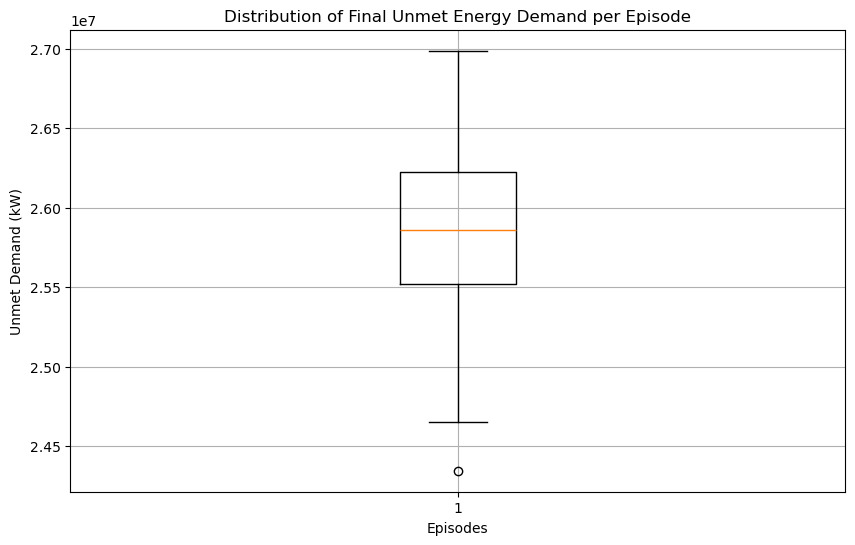

In [26]:
log_directory = '../data/efficient_baseline_logs/'
demand = parse_logs_and_plot(log_directory)

In [27]:
demand.mean()

25867402.354994126